In [117]:
import numpy as np
import pandas as pd

from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from rfpimp import *

import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

# make prettier plots
%config InlineBackend.figure_format = 'svg' 

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
file = open('cleaned_cc_default_data', 'rb')
model_data = pickle.load(file)

In [3]:
model_data.head()

,default_payment_next_month,age,education_level,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,sex,others,single
0,0,39,3.0,47174,47974,48630,50803,30789,15874,0,0,0,0,0,0,1800,2000,3000,2000,2000,2000,50000,1,0,1
1,0,29,3.0,48088,45980,44231,32489,26354,20221,0,0,0,0,0,0,2000,2010,3000,3000,3000,1000,110000,0,0,1
2,0,36,3.0,78630,68921,46512,40335,37165,22156,0,0,0,2,0,0,10076,4018,14,2051,2000,0,270000,1,0,1
3,0,45,3.0,58180,59134,61156,62377,63832,65099,0,0,0,0,0,0,2886,2908,2129,2354,2366,2291,130000,1,0,0
4,0,24,3.0,42058,35340,22110,19837,19855,20151,0,0,0,0,0,0,1367,1606,692,709,721,692,50000,1,0,1


In [4]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2963 entries, 0 to 2964
Data columns (total 25 columns):
default_payment_next_month    2963 non-null int64
age                           2963 non-null int64
education_level               2963 non-null float64
bill_amt_1                    2963 non-null int64
bill_amt_2                    2963 non-null int64
bill_amt_3                    2963 non-null int64
bill_amt_4                    2963 non-null int64
bill_amt_5                    2963 non-null int64
bill_amt_6                    2963 non-null int64
pay_0                         2963 non-null int64
pay_2                         2963 non-null int64
pay_3                         2963 non-null int64
pay_4                         2963 non-null int64
pay_5                         2963 non-null int64
pay_6                         2963 non-null int64
pay_amt_1                     2963 non-null int64
pay_amt_2                     2963 non-null int64
pay_amt_3                     2963 non-nu

In [5]:
model_data.shape


(2963, 25)

# Splitting data into train/test & scaling

In [6]:
# Stratified train test split
x_raw = model_data.iloc[:, 1:]
y_raw = np.array(model_data['default_payment_next_month'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_train, x_test = x_raw.loc[train_index,:], x_raw.loc[test_index,:]
    y_train, y_test = y_raw[train_index], y_raw[test_index]

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [7]:
x_train.shape

(2370, 24)

In [8]:
y_train.shape

(2370,)

In [9]:
x_test.shape

(593, 24)

In [10]:
y_test.shape

(593,)

In [11]:
# setting a scaler

scaler = StandardScaler()

In [12]:
type(x_train)

pandas.core.frame.DataFrame

In [13]:
x_train.columns

Index(['age', 'education_level', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
       'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_0', 'pay_2', 'pay_3',
       'pay_4', 'pay_5', 'pay_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3',
       'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'limit_balance', 'sex', 'others',
       'single'],
      dtype='object')

In [14]:
# splitting train data into features that will be scaled
# by dropping categorical features

X_for_scaling = x_train.drop(columns=['education_level', 
        'pay_0', 'pay_2', 'pay_3','pay_4', 'pay_5', 'pay_6', 
        'sex', 'others', 'single'])

In [15]:
# scale features that need to be scaled

X_train_scaled = scaler.fit_transform(X_for_scaling)

In [16]:
# convert those features to data frame

X_train_scaled = pd.DataFrame(X_train_scaled, columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance'])

In [17]:
X_train_scaled.head()


,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance
0,0.098135,-0.718157,-0.712797,-0.656081,-0.662030,-0.676581,-0.449010,-0.295507,-0.084792,-0.140569,-0.215248,0.570493,-0.248511,-0.019936
1,-0.885615,-0.045978,-0.046877,-0.134033,-0.063341,-0.001423,0.066774,-0.218995,-0.137506,-0.239268,-0.211688,-0.087358,-0.281494,-0.906082
2,1.300495,-0.028908,-0.032205,0.022519,0.102790,-0.656869,-0.702595,-0.295507,-0.122803,-0.198000,-0.328832,-0.294460,2.123603,-0.906082
3,-0.776309,3.168099,3.125140,3.332646,3.805802,3.916929,1.252276,-0.295281,0.117521,0.333052,0.173641,-0.292388,10.970793,0.946770
4,0.972579,0.179921,-0.213537,-0.207158,0.790165,0.447903,0.392444,-0.069978,-0.104321,4.464748,-0.153223,-0.111723,-0.149560,-0.100494


In [18]:
# merge scaled features with non-scaled features

# X_train = pd.merge(X_train_scaled, x_train.drop(columns=['age',  
#         'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
#         'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
#          'limit_balance']).reset_index(drop=True), left_index=True, right_index=True)

X_train = X_train_scaled.join(x_train.drop(columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance']).reset_index(drop=True))

In [107]:
X_train.head()


,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,sex,others,single
0,0.098135,-0.718157,-0.712797,-0.656081,-0.662030,-0.676581,-0.449010,-0.295507,-0.084792,-0.140569,-0.215248,0.570493,-0.248511,-0.019936,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.885615,-0.045978,-0.046877,-0.134033,-0.063341,-0.001423,0.066774,-0.218995,-0.137506,-0.239268,-0.211688,-0.087358,-0.281494,-0.906082,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.300495,-0.028908,-0.032205,0.022519,0.102790,-0.656869,-0.702595,-0.295507,-0.122803,-0.198000,-0.328832,-0.294460,2.123603,-0.906082,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.776309,3.168099,3.125140,3.332646,3.805802,3.916929,1.252276,-0.295281,0.117521,0.333052,0.173641,-0.292388,10.970793,0.946770,3.0,1.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
4,0.972579,0.179921,-0.213537,-0.207158,0.790165,0.447903,0.392444,-0.069978,-0.104321,4.464748,-0.153223,-0.111723,-0.149560,-0.100494,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [20]:
X_train.shape


(2370, 24)

In [21]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 24 columns):
age                2368 non-null float64
bill_amt_1         2368 non-null float64
bill_amt_2         2368 non-null float64
bill_amt_3         2368 non-null float64
bill_amt_4         2368 non-null float64
bill_amt_5         2368 non-null float64
bill_amt_6         2368 non-null float64
pay_amt_1          2368 non-null float64
pay_amt_2          2368 non-null float64
pay_amt_3          2368 non-null float64
pay_amt_4          2368 non-null float64
pay_amt_5          2368 non-null float64
pay_amt_6          2368 non-null float64
limit_balance      2368 non-null float64
education_level    2368 non-null float64
pay_0              2368 non-null float64
pay_2              2368 non-null float64
pay_3              2368 non-null float64
pay_4              2368 non-null float64
pay_5              2368 non-null float64
pay_6              2368 non-null float64
sex                2368 non-null

In [23]:
# get null value indices in X_train

inds = pd.isnull(X_train).any(1).nonzero()[0]
inds

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  This is separate from the ipykernel package so we can avoid doing imports until


array([1391, 1867])

In [24]:
# drop the above indices with null values from X_train and y_train

X_train.drop([1391, 1867], inplace = True)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2369
Data columns (total 24 columns):
age                2368 non-null float64
bill_amt_1         2368 non-null float64
bill_amt_2         2368 non-null float64
bill_amt_3         2368 non-null float64
bill_amt_4         2368 non-null float64
bill_amt_5         2368 non-null float64
bill_amt_6         2368 non-null float64
pay_amt_1          2368 non-null float64
pay_amt_2          2368 non-null float64
pay_amt_3          2368 non-null float64
pay_amt_4          2368 non-null float64
pay_amt_5          2368 non-null float64
pay_amt_6          2368 non-null float64
limit_balance      2368 non-null float64
education_level    2368 non-null float64
pay_0              2368 non-null float64
pay_2              2368 non-null float64
pay_3              2368 non-null float64
pay_4              2368 non-null float64
pay_5              2368 non-null float64
pay_6              2368 non-null float64
sex                2368 non-null

In [28]:
# converted y_train into a dataframe so I can deal with null values in x_train

y_train = pd.DataFrame(y_train, columns=['credit_card_default'])
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2370 entries, 0 to 2369
Data columns (total 1 columns):
credit_card_default    2370 non-null int64
dtypes: int64(1)
memory usage: 18.6 KB


In [29]:
# drop same rows with null values from y_train

y_train.drop([1391, 1867], inplace = True)
y_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2368 entries, 0 to 2369
Data columns (total 1 columns):
credit_card_default    2368 non-null int64
dtypes: int64(1)
memory usage: 37.0 KB


In [31]:
# split test data into features that will be scaled by dropping categorical features (same process as train data)

X_for_scaling2 = x_test.drop(columns=['education_level', 
        'pay_0', 'pay_2', 'pay_3','pay_4', 'pay_5', 'pay_6', 
        'sex', 'others', 'single'])

In [32]:
# scale test features

X_test_scaled = scaler.fit_transform(X_for_scaling2)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [33]:
# convert those features to dataframe

X_test_scaled = pd.DataFrame(X_test_scaled, columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance'])

In [108]:
X_test_scaled.head()


,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance
0,-1.069387,-0.669816,-0.690259,-0.685146,-0.701047,-0.677536,-0.618999,-0.174529,-0.316118,-0.257875,-0.278114,-0.053508,0.005040,-0.677296
1,-1.181447,0.529878,0.555763,0.595420,0.707323,0.745784,0.783411,-0.160034,-0.201492,-0.114393,-0.118358,-0.108354,-0.126936,-0.521743
2,-0.621148,-0.726695,-0.724196,-0.683525,-0.715030,-0.689791,-0.671155,-0.329468,-0.312724,-0.322275,-0.349943,-0.218100,-0.213862,-0.366191
3,-1.405566,-0.140866,-0.111371,-0.280651,-0.251998,-0.190407,-0.177510,-0.243260,-0.316118,-0.271194,-0.324452,-0.234397,-0.196285,-0.910624
4,0.723570,2.604362,2.571945,2.404252,2.511060,2.601686,2.431268,0.173286,0.099860,0.150625,0.294966,0.047505,-0.015585,1.500438


In [35]:
# merge with categorical features that weren't scaled

# X_test = pd.merge(X_test_scaled, x_test.drop(columns=['age',  
#         'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
#         'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
#          'limit_balance']).reset_index(drop=True), left_index=True, right_index=True)

X_test = X_test_scaled.join(x_test.drop(columns=['age', 
       'bill_amt_1', 'bill_amt_2', 'bill_amt_3','bill_amt_4', 'bill_amt_5', 'bill_amt_6', 
       'pay_amt_1', 'pay_amt_2', 'pay_amt_3','pay_amt_4', 'pay_amt_5', 'pay_amt_6', 
       'limit_balance']).reset_index(drop=True))

In [109]:
X_test.head()


,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,limit_balance,education_level,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,sex,others,single
0,-1.069387,-0.669816,-0.690259,-0.685146,-0.701047,-0.677536,-0.618999,-0.174529,-0.316118,-0.257875,-0.278114,-0.053508,0.005040,-0.677296,3.0,0,0,0,0,0,0,0,0,1
1,-1.181447,0.529878,0.555763,0.595420,0.707323,0.745784,0.783411,-0.160034,-0.201492,-0.114393,-0.118358,-0.108354,-0.126936,-0.521743,2.0,0,0,0,0,0,0,1,0,1
2,-0.621148,-0.726695,-0.724196,-0.683525,-0.715030,-0.689791,-0.671155,-0.329468,-0.312724,-0.322275,-0.349943,-0.218100,-0.213862,-0.366191,1.0,0,0,0,0,0,0,0,0,0
3,-1.405566,-0.140866,-0.111371,-0.280651,-0.251998,-0.190407,-0.177510,-0.243260,-0.316118,-0.271194,-0.324452,-0.234397,-0.196285,-0.910624,2.0,0,0,0,0,0,0,0,0,0
4,0.723570,2.604362,2.571945,2.404252,2.511060,2.601686,2.431268,0.173286,0.099860,0.150625,0.294966,0.047505,-0.015585,1.500438,1.0,0,0,0,0,0,0,1,0,0


In [37]:
X_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 24 columns):
age                593 non-null float64
bill_amt_1         593 non-null float64
bill_amt_2         593 non-null float64
bill_amt_3         593 non-null float64
bill_amt_4         593 non-null float64
bill_amt_5         593 non-null float64
bill_amt_6         593 non-null float64
pay_amt_1          593 non-null float64
pay_amt_2          593 non-null float64
pay_amt_3          593 non-null float64
pay_amt_4          593 non-null float64
pay_amt_5          593 non-null float64
pay_amt_6          593 non-null float64
limit_balance      593 non-null float64
education_level    593 non-null float64
pay_0              593 non-null int64
pay_2              593 non-null int64
pay_3              593 non-null int64
pay_4              593 non-null int64
pay_5              593 non-null int64
pay_6              593 non-null int64
sex                593 non-null int64
others             593 non-nu

In [63]:
# pickle column names to use later in Flask app

column_names = list(X_train.columns)

with open('column_names.pkl', 'wb') as f:
    pickle.dump(column_names, f)
    

# Modeling Round I

- KNN
- Logistic Regression
- SVM
- Naive Bayes
- Random Forest


- add XGBoost ?


In [232]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

### KNN GridSearchCV

In [43]:
# Run CV with 5 folds (knn)

ks = range(1,301,50)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0897s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s finished
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_neighbors': range(1, 301, 50)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [44]:
# best model for KNN

knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=51, p=2,
           weights='uniform')

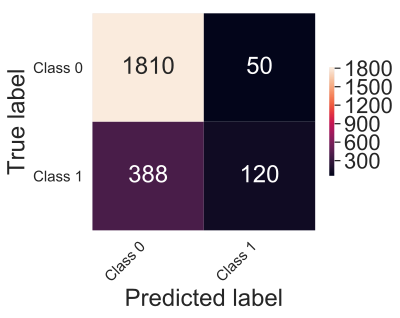

In [231]:
cm = print_confusion_matrix(confusion_matrix(y_train, knn_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Logistic Regression GridSearchCV

In [47]:
# Run CV with 5 folds (logit)

penalty = ['l1', 'l2'] # look into doing elastic net here to see what combo of l1 and l2 is best
C = np.logspace(-3, 1, 100)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1020s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1314s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1952s.) Setting batch_size=12.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 420 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 864 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.09750e-03, ..., 9.11163e+00, 1.00000e+01]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [48]:
# best model for logistic regression (metric = C)

logistic_grid.best_estimator_

LogisticRegression(C=0.26560877829466867, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

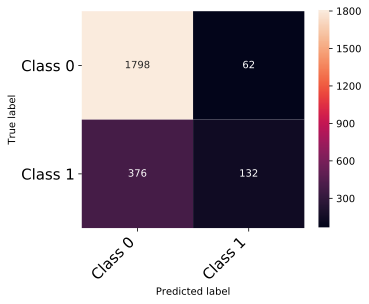

In [49]:
cm = print_confusion_matrix(confusion_matrix(y_train, logistic_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

In [149]:
logistic2 = linear_model.LogisticRegression(C=0.02848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) # ADD PARAMETERS FROM BEST ESTIMATE
logistic2.fit(X_train, y_train)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.02848035868435802, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [153]:
X_train.columns

Index(['age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4',
       'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3',
       'pay_amt_4', 'pay_amt_5', 'pay_amt_6', 'limit_balance',
       'education_level', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
       'sex', 'others', 'single'],
      dtype='object')

In [247]:
df_a.to_excel("logit_feature_importances.xlsx", sheet_name='logit')

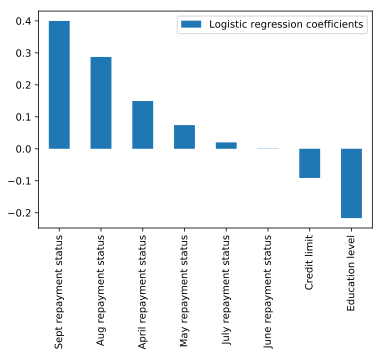

In [196]:
a = logistic2.coef_
df_a = pd.DataFrame(a, columns = ['Age', 'Sept bill', 'Aug bill', 'July bill', 'June bill','May bill', 'April bill', 
                                  'Sept payment', 'Aug payment', 'July payment', 'June payment', 'May payment', 'April payment',
                                  'Credit limit', 'Education level',
                                  'Sept repayment status', 'Aug repayment status', 'July repayment status', 'June repayment status', 'May repayment status', 'April repayment status',
                                  'Gender', 'Marital status, others', 'Marital status, single'])
df_a = df_a.transpose()
df_a.rename({df_a.columns.values[0]:'Logistic regression coefficients'}, axis='columns', inplace=True)
df_a.sort_values(by='Logistic regression coefficients', ascending=False, inplace=True)
df_a = df_a[(df_a.T != 0).any()]
df_a.plot.bar()

plt.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/logit_feature_importances.png', dpi=300, bbox_inches = 'tight')


# scale this upwards for better aesthetics


# in the most recent months, the later they are in makign their payment, the more likely they are to default

# pay_# are not colinear because, for example, if in August, may pay_2 = 4, then I pay off my bills
# then in Sept my pay_0 would = 0; so if you just looked at Sept, you would think I have a clean history,
# but really I don't, which is why you need all 6 months into the past

# higher credit limit --> less likely to default
# higher education level --> less likely to default


## RF vs logistic
# logistic features made more intuitive sense when I loked at thtme, even though features are a bit differnece
# ultimately I would recommend ensembling them
# or I would recomend running logistic in background as sanity check against RF
# because when I look at logistic coefficients they make common sense; 
# so when this one says something very different from model I'm actually recommending, that's a warning sign

### SVM GridSearchCV

In [50]:
# Run CV with 5 folds (SVM)

C = np.logspace(-3, 1, 25)
gammas = np.logspace(-3, 0, 25)
param_grid = dict(C=C, gamma=gammas)

svm1 = svm.SVC(kernel='rbf', probability=True)
svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.46780e-03, 2.15443e-03, 3.16228e-03, 4.64159e-03,
       6.81292e-03, 1.00000e-02, 1.46780e-02, 2.15443e-02, 3.16228e-02,
       4.64159e-02, 6.81292e-02, 1.00000e-01, 1.46780e-01, 2.15443e-01,
       3.16228e-01, 4.64159e-01, 6.81292e-01, 1.00000e+00, 1.46780e..., 0.07499, 0.1    , 0.13335, 0.17783, 0.23714, 0.31623,
       0.4217 , 0.56234, 0.74989, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [51]:
svm_grid.best_estimator_

SVC(C=4.6415888336127775, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.042169650342858224,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

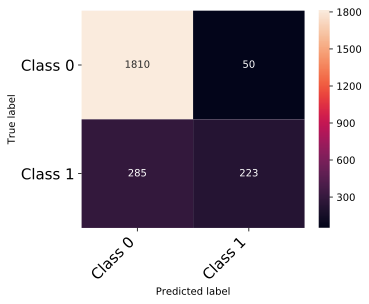

In [53]:
cm = print_confusion_matrix(confusion_matrix(y_train, svm_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Naive Bayes Model

In [54]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(X_train, y_train)

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


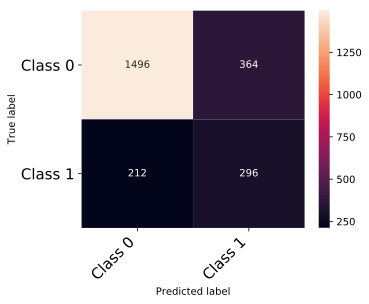

In [55]:
cm = print_confusion_matrix(confusion_matrix(y_train, gnb_best.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

### Random Forest GridSearchCV

In [30]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], # what is this?
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [50, 100, None], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 3, 5, 10], 'n_estimators': [100, 200, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [58]:
rf_grid.best_params_


{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 200}

In [38]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [59]:
# rf_model with best params

rf_model = RandomForestClassifier(bootstrap = True, max_depth = None, max_features = 'sqrt', min_samples_leaf = 10, 
                                  min_samples_split = 10, n_estimators = 200)


In [60]:
# final model to pickle to use in Flask app

model = rf_model.fit(X_train, np.array(y_train))


/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [61]:
# pickling final model for Flask app

filename = 'credit_card_default_model.sav'
pickle.dump(model, open(filename, 'wb'))



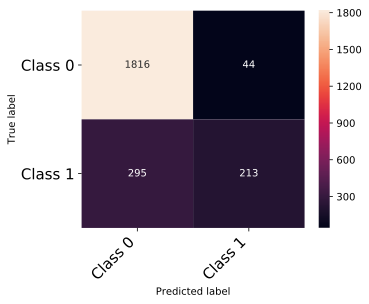

In [42]:
cm = print_confusion_matrix(confusion_matrix(y_train, rf_grid.predict(X_train)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

In [65]:
# Random Forest Feature Importances

rf2 = RandomForestRegressor(n_estimators=200, max_depth = None)
rf2.fit(X_train, y_train)
rf2.feature_importances_

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


array([0.07263714, 0.06399901, 0.04667479, 0.0475653 , 0.0404544 ,
       0.05064551, 0.05177444, 0.04841766, 0.05779433, 0.05199262,
       0.04721696, 0.05067579, 0.06521747, 0.06268143, 0.01920371,
       0.07997947, 0.08162229, 0.00888826, 0.00857157, 0.01038424,
       0.01216103, 0.00987551, 0.00220695, 0.00936011])

In [242]:
# zip each feature importance weight with my columns

rf_feature_importances = pd.DataFrame(zip(list(rf2.feature_importances_), X_train.columns), columns=['feature_importances', 'feature_names'])
rf_feature_importances.sort_values(by='feature_importances')

,feature_importances,feature_names
22,0.002207,others
18,0.008572,pay_4
17,0.008888,pay_3
23,0.009360,single
21,0.009876,sex
19,0.010384,pay_5
20,0.012161,pay_6
14,0.019204,education_level
4,0.040454,bill_amt_4
2,0.046675,bill_amt_2


In [140]:
# Graph feature importances using train dataset

imp = importances(rf2, X_train, y_train)

In [245]:
# rename index labels to improve readability of feature importances visualization

imp['Feature2'] = imp.index

imp['Feature2'] = imp['Feature2'].map({'pay_0': 'Sept repayment status', 'limit_balance': 'Credit limit',
                                     'pay_2': 'Aug repayment status', 'pay_amt_2': 'Aug payment', 'bill_amt_3': 'July bill', 
                                     'pay_amt_6': 'April payment', 'age': 'Age', 'bill_amt_6': 'April bill', 'bill_amt_5': 'May bill',
                                     'bill_amt_1': 'Sept bill', 'pay_amt_3': 'July payment', 'pay_amt_5': 'Aug payment', 
                                     'bill_amt_2': 'Aug bill', 'pay_amt_1': 'Sept payment', 'bill_amt_4': 'July bill', 'pay_amt_4': 'July payment', 
                                     'pay_3': 'July repayment status', 'pay_4': 'June repayment status', 'pay_6': 'April repayment status', 
                                     'education_level': 'Education Level', 'pay_5': 'May repayment status', 'single': 'Marital status, single',
                                     'sex': 'Gender', 'others': 'Marital status: others'})

# imp.drop(columns=['Feature'], axis=1, inplace=True)

imp.set_index('Feature2', inplace = True)

imp

# imp.to_excel


,Importance
Feature2,
NaN,0.275792
NaN,0.234977
NaN,0.211774
NaN,0.184154
NaN,0.159243
NaN,0.143494
NaN,0.139147
NaN,0.106608
NaN,0.103915


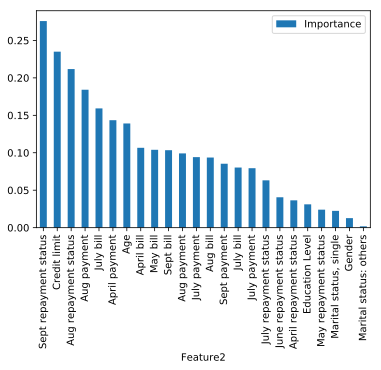

In [195]:
imp.plot.bar()
plt.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/RF_feature_importances_2.png', dpi=300, bbox_inches = 'tight')


# scale this upwards for better aesthetics

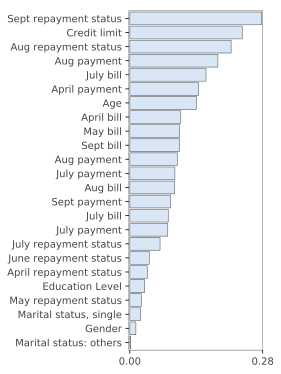

In [146]:
# plot of feature importances

viz = plot_importances(imp)
plt.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/RF_feature_importances.png', dpi=300, bbox_inches = 'tight')
viz.view()


In [ ]:
# predicted y values based on final model

y_pred = model.predict_proba(X_test)[:,1]

### XGBoost

In [ ]:
# run later and do feature importances?

# Scoring the models

### ROC_AUC

In [113]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for knn: 0.7213
Best ROC_AUC for logit: 0.7212
Best ROC_AUC for svm: 0.7279
Best ROC_AUC for rf: 0.7436


### Best parameters

In [57]:
print('Best Params for knn: ', knn_grid.best_params_)
print('Best Patams for logit: ', logistic_grid.best_params_)
print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for knn:  {'n_neighbors': 51}
Best Patams for logit:  {'C': 0.26560877829466867, 'penalty': 'l1'}
Best Params for svm:  {'C': 4.6415888336127775, 'gamma': 0.042169650342858224}
Best Params for rf:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}


### F1 Scores

In [96]:
y_true.shape

(593,)

In [99]:
y_pred.shape

(593,)

In [91]:
# Generate data frame of model test statistics

y_probs = model.predict_proba(X_test)[:,1]
thresholds = []
precisions = []
recall = []
tn = []
fp = []
fn = []
tp = []

for t in range(0,105,10):
    y_pred = pd.Series(y_probs).apply(lambda x: 0 if x<t/100 else 1)
    thresholds.append(t/100)
    precisions.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    tn.append(confusion_matrix(y_test, y_pred)[0][0])
    fp.append(confusion_matrix(y_test, y_pred)[0][1])
    fn.append(confusion_matrix(y_test, y_pred)[1][0])
    tp.append(confusion_matrix(y_test, y_pred)[1][1])


test_statistics = pd.DataFrame(
    {'Threshold': thresholds,
     'Precision': precisions,
     'Recall' : recall,
     'True_Negative': tn,
     'False_Positive': fp,
     'False_Negative': fn,
     'True_Positive': tp,
    })

test_statistics

/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laurenfinkelstein/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Threshold,Precision,Recall,True_Negative,False_Positive,False_Negative,True_Positive
0,0.0,0.214165,1.000000,0,466,0,127
1,0.1,0.227017,0.952756,54,412,6,121
2,0.2,0.371901,0.708661,314,152,37,90
3,0.3,0.615385,0.566929,421,45,55,72
4,0.4,0.677419,0.496063,436,30,64,63
5,0.5,0.698630,0.401575,444,22,76,51
6,0.6,0.771429,0.212598,458,8,100,27
7,0.7,0.785714,0.086614,463,3,116,11
8,0.8,1.000000,0.007874,466,0,126,1
9,0.9,0.000000,0.000000,466,0,127,0


In [251]:
# score on F1
# tuning thresholds on F1 score

y_true = y_test

# Using a threshold of 0.3 (based on above dataframe of test statistics)
# which means that anything above a probability of 0.3 will be classified as positive
y_predict = (model.predict_proba(X_test)[:, 1] > 0.2)
f1_score(y_true, y_predict)


## Note: I would want to improve the model later, but this score is decent

0.49582172701949856

In [204]:
# Use test set to measure model performance

y_pred = model.predict_proba(X_test)

cutoff = 0.1

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_test, y_class)
print(conf_mat)
my_default_rate = conf_mat[1,0]/(conf_mat[0,0] + conf_mat[1,0])
total_default_rate = np.sum(conf_mat, axis=1)[1]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
print('Test Set Default Rate of Model Loans %.2f' % (my_default_rate*100), '%')
print('Test Set Default Rate of All Loans %.2f' % (total_default_rate*100), '%')

[[ 54 412]
 [  6 121]]
Test Set Default Rate of Model Loans 10.00 %
Test Set Default Rate of All Loans 21.42 %


<Figure size 1800x1200 with 0 Axes>

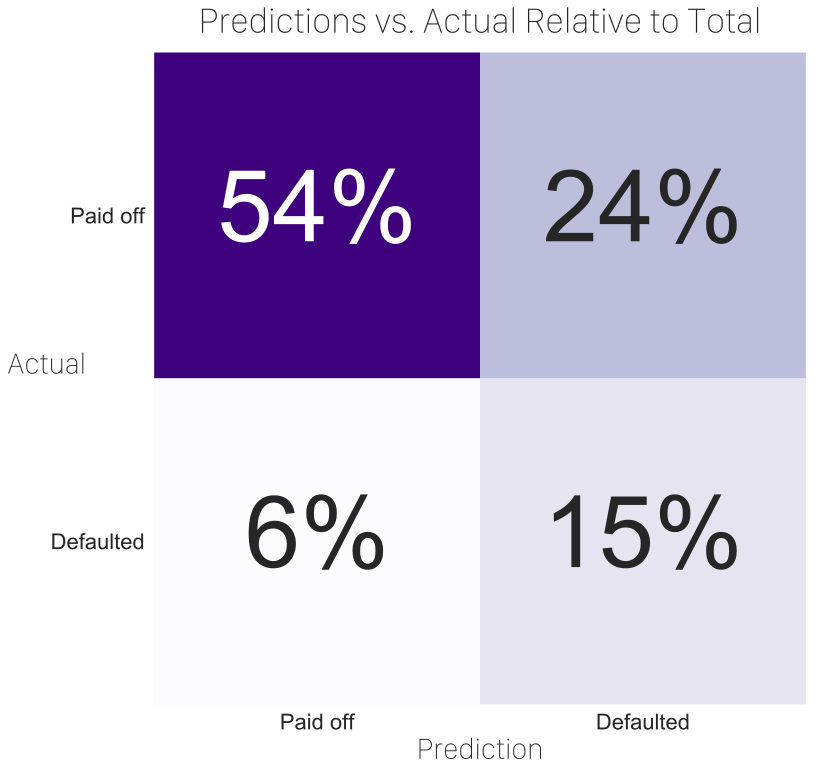

In [253]:
## Jeremy's confusion matrix code

# Make Confusion Matrix with percentages
cm_test = confusion_matrix(y_test,model.predict_proba(X_test)[:,1]>=.2)
mat_confusion_test= cm_test.astype('float') / cm_test.sum()
mat_confusion_test = mat_confusion_test.round(2)

plt.figure(dpi=300);
plt.figure(figsize=(12, 12));

sns.set(font_scale=2)
sns.heatmap(mat_confusion_test, cmap=plt.cm.Purples, annot=True, square=True,
            fmt='.0%', cbar = False, annot_kws={"size": 100},
       xticklabels=['Paid off', 'Defaulted'],
       yticklabels=['Paid off', 'Defaulted']);
plt.xlabel('Prediction',fontname = '.SF Compact Display',fontsize = 30,fontweight = 'bold')
plt.ylabel('Actual',fontname = '.SF Compact Display',fontsize = 30,rotation = 0)
plt.yticks(rotation = 0)
plt.title('Predictions vs. Actual Relative to Total',fontname = '.SF Compact Display',fontsize = 36,pad = 20);
plt.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/jeremy_cm_rf_F1', dpi=300, bbox_inches = "tight")

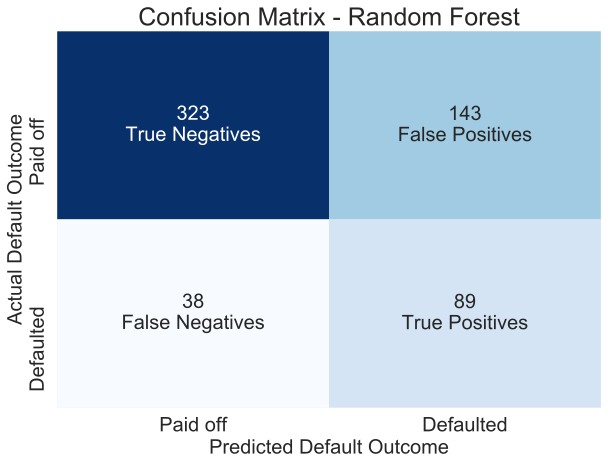

In [250]:
## Natasha's confusion matrix code

cm = confusion_matrix(y_test,model.predict_proba(X_test)[:,1]>=0.2)
plt.figure(figsize=(25,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
               annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
             'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
   t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix - Random Forest', size=25)
plt.xlabel('Predicted Default Outcome', size=20)
plt.ylabel('Actual Default Outcome', size=20)
labels = ['Paid off', 'Defaulted']
ax.set_xticklabels(labels, size = 20)
ax.set_yticklabels(labels, size = 20)
plt.tight_layout()
plt.savefig('Confusion_matrix_Logistic.png')
plt.savefig('Confusion_matrix_Logistic.svg')
plt.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/natasha_cm_rf_F1', dpi=300, bbox_inches = "tight")
plt.show()

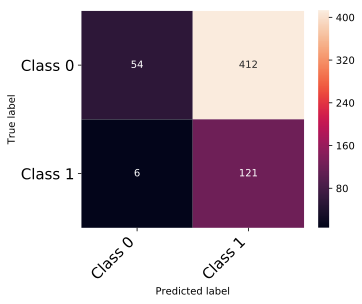

In [205]:
# confusion matrix on final RF model
model = pickle.load(open('flask_app/credit_card_default_model.sav', 'rb'))
cm = print_confusion_matrix(confusion_matrix(y_test, y_class), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)

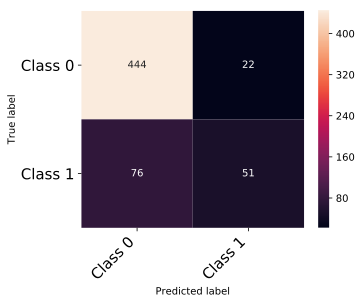

In [198]:
# confusion matrix on final RF model
model = pickle.load(open('flask_app/credit_card_default_model.sav', 'rb'))
cm = print_confusion_matrix(confusion_matrix(y_test, model.predict(X_test)), ['Class 0', 'Class 1'], figsize=(5, 4), fontsize=15)
cm.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/rf_final_model_cm.png', dpi=300, bbox_inches = 'tight')


#### NOTE QUESTIONS IN BELOW COMMENTED CODE

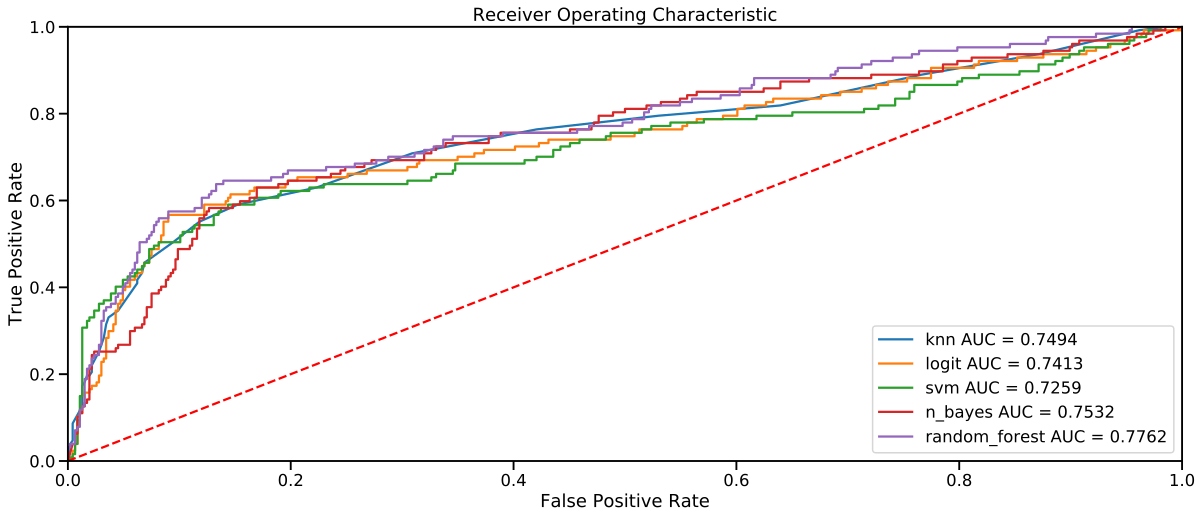

In [218]:
# ROC for all the models

sns.set_context("talk")


model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svm_grid.best_estimator_, 
              gnb_best, 
              rf_grid.best_estimator_]
model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(20,8))
for i, model in enumerate(model_list):
    y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))


plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('/Users/laurenfinkelstein/Metis/Projects/Project 3/credit_payment_default/ROC-AUC_curves.png', dpi=300, bbox_inches = 'tight')
plt.show()